# AAND - BCI Exercise Sheet #03

#### Name: Luke Longren

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output

import bci_minitoolbox as bci

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (10, 5)

## Exercise 1: Nearest Centroid Classifier (NCC)  (1 point)
Implement the calculation of the nearest centroid classifier (NCC) as a Python function `train_NCC`.  The function should take two arguments, the first being the data matrix $\bf{X}$ where each column is a data point ($\bf{x_k}$), and the second being class labels of the data points. Two output arguments should return the weight vector **`w`** and bias `b`.

In [3]:
def train_NCC(X, y):
    '''
    Synopsis:
        w, b = train_NCC(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: NCC weight vector'
        b: bias term
    '''
    # only the means of the distributions are known
    # separate the two classes
    data1 = X[:, np.where(y == 0)]
    data2 = X[:, np.where(y == 1)]
    # find the means
    mean1 = np.mean(data1[:,0,:], axis=1)
    mean2 = np.mean(data2[:,0,:], axis=1)
    # calculate the weight vector
    w = (mean2 - mean1) / abs(mean2 - mean1)
    # calculate the bias term
    b = w.T @ (mean1 + mean2) / 2
    return w, b

## Exercise 2: Linear Discriminant Analysis (LDA)  (3 points)
Implement the calculation of the LDA classifier as a Python function `train_LDA`.  The function should take two arguments, the first being the data matrix $\bf{X}$ where each column is a data point ($\bf{x_k}$), and the second being class labels of the data points. Two output arguments should return the weight vector **`w`** and bias `b`.

In [4]:
def train_LDA(X, y):
    '''
    Synopsis:
        w, b = train_LDA(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: LDA weight vector
        b: bias term
    '''
    # separate the two classes
    data1 = X[:, np.where(y == 0)][:,0,:]
    data2 = X[:, np.where(y == 1)][:,0,:]
    # find the means
    mean1 = np.mean(data1, axis=1)
    mean2 = np.mean(data2, axis=1)
    # number of samples in each 
    N1 = data1.shape[1]
    N2 = data2.shape[1]
    # need to estimate sigma from the data
    # estimate covariance matrices
    cov1 = np.cov(data1, rowvar=True)
    cov2 = np.cov(data2, rowvar=True)
    # weighted average of the two
    sigma = ((N1-1)/(N1+N2-1)) * cov1 + ((N2-1)/(N1+N2-1)) * cov2
    # calculate the weight vector
    w = np.linalg.inv(sigma) @ (mean2 - mean1)
    # calculate the bias term
    b = w.T @ (mean1 + mean2) / 2
    return w, b

## Exercises 3: Cross-validation with weighted loss (1 point)
Complete the implementation of `crossvalidation` by writing a loss function `loss_weighted_error` which calculates the weighted loss as explained in the lecture.

In [5]:
def crossvalidation(classifier_fcn, X, y, nFolds=10, verbose=False):
    '''
    Synopsis:
        loss_te, loss_tr = crossvalidation(classifier_fcn, X, y, nFolds=10, verbose=False)
    Arguments:
        classifier_fcn: handle to function that trains classifier as output w, b
        X:              data matrix (features X samples)
        y:              labels with values 0 and 1 (1 x samples)
        nFolds:         number of folds
        verbose:        print validation results or not
    Output:
        loss_te: value of loss function averaged across test data
        loss_tr: value of loss function averaged across training data
    '''
    nDim, nSamples = X.shape
    inter = np.round(np.linspace(0, nSamples, num=nFolds + 1)).astype(int)
    perm = np.random.permutation(nSamples)
    errTr = np.zeros([nFolds, 1])
    errTe = np.zeros([nFolds, 1])

    for ff in range(nFolds):
        idxTe = perm[inter[ff]:inter[ff + 1] + 1]
        idxTr = np.setdiff1d(range(nSamples), idxTe)
        w, b = classifier_fcn(X[:, idxTr], y[idxTr])
        out = w.T.dot(X) - b
        errTe[ff] = loss_weighted_error(out[idxTe], y[idxTe])
        errTr[ff] = loss_weighted_error(out[idxTr], y[idxTr])

    if verbose:
        print('{:5.1f} +/-{:4.1f}  (training:{:5.1f} +/-{:4.1f})  [using {}]'.format(errTe.mean(), errTe.std(),
                                                                                     errTr.mean(), errTr.std(), 
                                                                                     classifier_fcn.__name__))
    return np.mean(errTe), np.mean(errTr)

In [6]:
def loss_weighted_error(out, y):
    '''
    Synopsis:
        loss = loss_weighted_error( out, y )
    Arguments:
        out:  output of the classifier
        y:    true class labels
    Output:
        loss: weighted error
    '''
    # set the classifier output to 1s and 0s
    # this is to match the true class labels when compared
    for i in range(np.size(out)):
        if out[i] > 0: 
            out[i] = 1
        else:
            out[i] = 0
    # set initial error
    num_class1 = 0.
    num_class2 = 0.
    # if the classifier is incorrect, add one to the error
    for i in range(np.size(out)):
        if out[i] != y[i] and y[i] == 0:
            num_class1 += 1.
        elif out[i] != y[i] and y[i] == 1:
            num_class2 += 1.
    # calculate the percentage of incorrect responses
    # and avoid the divide by zero error
    if y[y==0].size != 0:
        errl_class1 = num_class1 / y[y==0].size
    if y[y==1].size != 0:
        errl_class2 = num_class2 / y[y==1].size
    # lastly, the weighted error between classes
    loss = 0.5 * (errl_class1 + errl_class2)  
    return loss

## Preparation: Load Data

In [7]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 4: Classification of Temporal Features  (2 points)
Extract as temporal features from single channels the epochs of the time interval 0 to 1000 ms. Determine the error of classification with LDA and with NCC on those features using 10-fold cross-validation for each single channel. Display the resulting (test) error rates for all channel as scalp topographies (one for LDA and one for NCC).

In [8]:
"""Extract epochs as temporal features from single channels"""
ival = [0, 1000]  # [ms]
# no baseline correction here
epo, epo_t = bci.makeepochs(X=cnt, fs=fs, mrk_pos=mrk_pos, ival=ival)  # epo: (samples x channels x epochs)
print(epo.shape)

(101, 55, 1200)


In [9]:
"""Determine error of classification, temporal, with both methods using 10-fold cross validation"""
NCC_error = np.zeros((epo.shape[1], 2))  # (channels, loss type), test/training
LDA_error = np.zeros((epo.shape[1], 2))  # (channels, loss type), test/training
for i in range(epo.shape[1]):
    NCC_error[i] = crossvalidation(classifier_fcn=train_NCC, X=epo[:,i,:], y=mrk_class, nFolds=10, verbose=False)
    LDA_error[i] = crossvalidation(classifier_fcn=train_LDA, X=epo[:,i,:], y=mrk_class, nFolds=10, verbose=False)

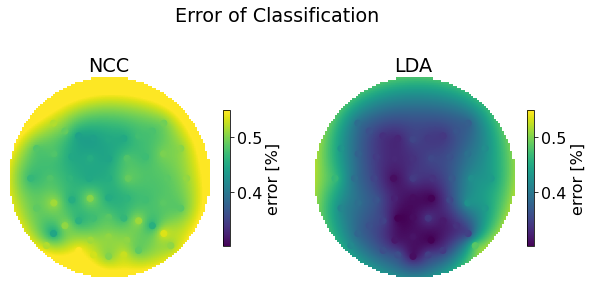

In [10]:
"""Display the error rates as scalp topographies"""
clim = [np.min([NCC_error[:,0], LDA_error[:,0]]), np.max([NCC_error[:,0], LDA_error[:,0]])]

fig, (ax1,ax2) = plt.subplots(1,2)
plt.sca(ax1)
bci.scalpmap(mnt=mnt, v=NCC_error[:,0], clim=clim, cb_label='error [%]')
plt.title('NCC')
plt.sca(ax2)
bci.scalpmap(mnt=mnt, v=LDA_error[:,0], clim=clim, cb_label='error [%]')
plt.title('LDA')
plt.suptitle('Error of Classification')
plt.show()

## Exercise 5: Classification of Spatial Features  (3 points)
Perform classification (*target* vs. *nontarget*) on spatial features (average across time within a 50 ms interval) in a time window that is shifted from 0 to 1000 ms in steps of 10 ms, again with both, LDA and NCC. Visualize the time courses of the classification error. Again, use 10-fold cross-validation. Here, use a baseline correction w.r.t. the prestimulus interval -100 to 0 ms.

In [11]:
"""Use a baseline correction here"""
ival = [0, 1000]  # [ms]
ref_ival = [-100, 0]  # [ms]
epo, epo_t = bci.makeepochs(X=cnt, fs=fs, mrk_pos=mrk_pos, ival=ival)  
baseline_epo = bci.baseline(epo=epo, epo_t=epo_t, ref_ival=ref_ival)  # baseline_epo: (samples x channels x epochs)

In [12]:
"""Average across time"""
index_num = 5  # 50 ms interval
time_points = baseline_epo.shape[0] - index_num
NCC_error = np.zeros(time_points)  # (channels, loss type), test/training
LDA_error = np.zeros(time_points)  # (channels, loss type), test/training
for t in range(1, time_points):  # loop over time
    for i in range(index_num):  # loop over interval index
        # average across the time interval
        NCC_error[t] += crossvalidation(classifier_fcn=train_NCC, X=baseline_epo[t+i,:,:], y=mrk_class, nFolds=10, verbose=False)[0]
        LDA_error[t] += crossvalidation(classifier_fcn=train_LDA, X=baseline_epo[t+i,:,:], y=mrk_class, nFolds=10, verbose=False)[0]
NCC_error = NCC_error/index_num
LDA_error = LDA_error/index_num

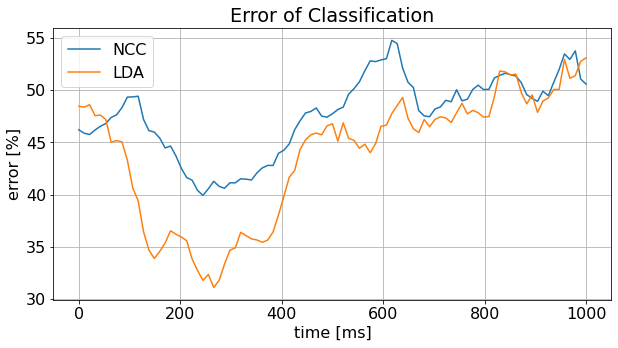

In [13]:
time_range = np.linspace(0, ival[1], time_points-1)
plt.plot(time_range, NCC_error[1:]*100, label='NCC')
plt.plot(time_range, LDA_error[1:]*100, label='LDA')
plt.title('Error of Classification')
plt.ylabel('error [%]')
plt.xlabel('time [ms]')
plt.legend()
plt.grid()
plt.show()

Below was the first attempt for the time course. Animating the scalp map may also be a good way to show loss over time:

In [14]:
# """Average across time"""
# window_size = 50  # interval of time average [ms]
# window_num = ival[1] // window_size  # number of windows
# time_step = ival[1] // (2*len(epo_t)) + 1  # indices for each step

# # take color map limits from the previous part
# NCC_clim = [np.min(NCC_error[:,0]), np.max(NCC_error[:,0])]
# LDA_clim = [np.min(LDA_error[:,0]), np.max(LDA_error[:,0])]
# NCC_clim = 'minmax'
# LDA_clim = 'minmax'

# # create a function to animate both of the classifier's time courses
# def animation_scalpmap(class_func, name, clim):
#     fig = plt.figure()
#     for t in range(window_num):  # loop over time windows
#         time_limits = [t*time_step, t*time_step+time_step]
#         error = np.zeros((baseline_epo.shape[1], 2))  # (channels, loss type), test/training
#         for i in range(baseline_epo.shape[1]):  # loop over channels
#             error[i] = crossvalidation(classifier_fcn=class_func, X=epo[time_limits[0]:time_limits[1],i,:], y=mrk_class, nFolds=10, verbose=False)
#         bci.scalpmap(mnt=mnt, v=error[:,0], clim=clim, cb_label='error')  # plot the scalp map
#         plt.title('%s, $t={0}-{1}$ms'.format(t*window_size, t*window_size+window_size) %name)
#         clear_output(wait=True)
#         display(fig)
#         plt.clf()

In [15]:
# animation_scalpmap(train_NCC, 'NCC', NCC_clim)

In [16]:
# animation_scalpmap(train_LDA, 'LDA', LDA_clim)